In [1]:
import os
import json
import subprocess
import numpy as np
import pandas as pd
import pickle as pkl
import nibabel as nib
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from os.path import join as pjoin
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from nilearn.glm.first_level import make_first_level_design_matrix

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

# define path
beta_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/beta'
fmriprep_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/fmriprep'
ciftify_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/derivatives/ciftify'
nifti_path = '/nfs/z1/zhenlab/BrainImageNet/action/data/bold/nifti'

/usr/local/neurosoft/anaconda3/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [23]:
def save_ciftifile(data, filename):
    template = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/Analysis_derivatives/ciftify/sub-core02/MNINonLinear/Results/ses-ImageNet01_task-object_run-1/ses-ImageNet01_task-object_run-1_Atlas.dtseries.nii'
    ex_cii = nib.load(template)
    ex_cii.header.get_index_map(0).number_of_series_points = data.shape[0]
    nib.save(nib.Cifti2Image(data.astype(np.float32), ex_cii.header), filename)

def roi_mask(roi_name):
    """
        roi_name : list or str
    """
    # load reference info
    main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
    roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
    roi_names = pd.read_csv(roi_name_path)
    roi = sio.loadmat(pjoin(main_path, 'MMP_mpmLR32k.mat'))['glasser_MMP']  # 1x59412

    # start load name
    roi_index = []
    if isinstance(roi_name, str):
        roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{roi_name}_ROI']).any(axis=1)].index[0]+1
        roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    else:
        for name in roi_name:
            roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{name}_ROI']).any(axis=1)].index[0]+1
            roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    return mask

# define path
main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'

Early_name = ['V1', 'V2', 'V3', 'V4']
Ventral_name = ['V8', 'PIT', 'FFC', 'VVC', 'VMV1', 'VMV2', 'VMV3']
MT_name = ['V3CD', 'V4t', 'LO1', 'LO2', 'LO3', 'FST', 'MST', 'MT', 'PH']
Dorsal_name = ['V3A', 'V3B', 'V6', 'V6A', 'V7', 'IPS1']
AIP_name = ['1', '2', '3a', '3b']
# VPM_name = ['6r', 'IFJp', 'IFJa', 'IFSp', '44']

roi_sum = ['Early', 'Ventral', 'MT', 'Dorsal', 'AIP']
for roi in roi_sum:
    exec(f'{roi}_mask = roi_mask({roi}_name)')
    print(eval(f'{roi}_mask').sum())


4193
1244
1349
1140
3736


#### Correlation distance across subjects. Here distinguishes same or different categories.
##### In this section, beta used are in the whole session model.

In [4]:
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances

# Load beta for 30 subjects 
sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub')])

mask_sum = ['EVC', 'DS', 'VTC', 'MT', 'AIP']

corr_same_sum = np.zeros((2, len(mask_sum)))
corr_diff_sum = np.zeros((2, len(mask_sum)))

n_sub = len(sub_names)
n_class = 180

beta_sum = np.zeros((n_sub, n_class, 59412))
for sub_idx, sub_name in enumerate(sub_names):
    # define beta path
    beta_sub_path = pjoin(beta_path, sub_name, f'{sub_name}_action-beta_clean.npy')
    beta_sub = np.load(beta_sub_path)
    scaler = StandardScaler()
    beta_sum[sub_idx] = scaler.fit_transform(beta_sub)

for mask_idx, mask_name in enumerate(mask_sum):
    mask = eval(f'{mask_name}_mask')
    beta_mask = beta_sum[:, :, mask]
    # compute correlation for same image
    corr_vector = np.zeros((n_class, int(n_sub*(n_sub-1)/2)))
    for image_idx in range(n_class):
        image_pattern = beta_mask[:, image_idx, :]
        # corr_matrix = np.corrcoef(image_pattern)
        # corr_triu = corr_matrix[np.triu(corr_matrix, k=1)!=0]
        corr_triu = pdist(image_pattern, 'correlation')
        corr_vector[image_idx] = corr_triu
    print('%s same image distance: %.3f'%(mask_name, corr_vector.mean()))
    corr_same_sum[0, mask_idx] = corr_vector.mean()
    corr_same_sum[1, mask_idx] = np.sqrt(corr_vector.std()/(n_class*int(n_sub*(n_sub-1)/2)))

    # compute correlation for different image
    corr_vector = np.zeros((n_class, n_class-1, int(n_sub*n_sub)))
    for image_idx_first in range(n_class):
        image_leave = np.delete(np.arange(n_class), image_idx_first)
        for idx, image_idx_second in enumerate(image_leave):
            # corr_matrix = np.corrcoef(beta_mask[:, image_idx_first, :], beta_mask[:, image_idx_second, :])[:n_sub, n_sub:]
            corr_matrix = pairwise_distances(beta_mask[:, image_idx_first, :], beta_mask[:, image_idx_second, :], metric='correlation')
            corr_vector[image_idx_first, idx] = corr_matrix.flatten()
    print('%s different image distance: %.3f'%(mask_name, corr_vector.mean()))
    corr_diff_sum[0, mask_idx] = corr_vector.mean()
    corr_diff_sum[1, mask_idx] = np.sqrt(corr_vector.std()/(n_class*(n_class-1)*n_sub*n_sub))


EVC same image distance: 0.984
EVC different image distance: 1.000
DS same image distance: 0.978
DS different image distance: 1.000
VTC same image distance: 0.976
VTC different image distance: 1.000
MT same image distance: 0.957
MT different image distance: 1.000
AIP same image distance: 0.974
AIP different image distance: 1.000


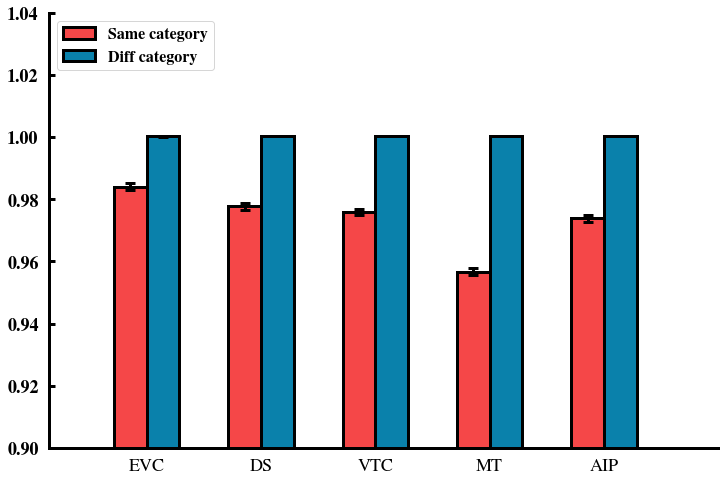

In [6]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import join as pjoin
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

corr_within_mean = corr_same_sum[0, :]
corr_within_std = corr_same_sum[1, :]
corr_between_mean = corr_diff_sum[0, :]
corr_between_std = corr_diff_sum[1, :]

width = 0.2
labels = mask_sum
x_1 = 0.7*np.arange(corr_within_mean.shape[0])
x_2 = x_1 + width

plt.figure(figsize=(12, 8))
plt.bar(x_1, corr_within_mean, yerr=corr_within_std, label='Same category', color='#F54748', 
        width=width, edgecolor='black', linewidth=3, error_kw=dict(lw=3, capsize=5, capthick=3), ecolor = "black")
plt.bar(x_2, corr_between_mean, yerr=corr_between_std, label='Diff category', color='#0A81AB', 
        width=width, edgecolor='black', linewidth=3, error_kw=dict(lw=3, capsize=5, capthick=3), ecolor = "black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax = plt.gca()
# ax.set_ylabel('Pattern Correlation', weight='bold', size=20, label)
ax.tick_params(labelsize=18, width=3, length=6, direction="in", pad=10)

plt.xticks((x_1 + x_2)/2, labels, weight='bold', fontsize=20)
plt.yticks(weight='bold')
plt.legend(loc='upper left', prop={'size':16, 'weight':'bold'})

ax.set_ylim(0.9, 1.04)
ax.set_xlim(-0.5, 3.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['bottom'].set_position(('data', 0.9))
ax.spines['left'].set_linewidth(3)

#### Correlation distance within subjects. In each subjects, each categories are presented 4 times. Here distinguishes same or different categories.
##### In this section, beta used are in the three-run model, which means three will be 180x4 beta for each subject.

In [3]:
from scipy.stats import pearsonr
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances

# Load beta for 30 subjects 
sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub') and int(i.split('-')[-1])<=30])

mask_sum = ['EVC', 'DS', 'VTC', 'MT', 'AIP']

corr_same_sum = np.zeros((len(sub_names), 2, len(mask_sum)))
corr_diff_sum = np.zeros((len(sub_names), 2, len(mask_sum)))

n_sub = len(sub_names)
n_class = 180
n_sess = 4

for sub_idx, sub_name in enumerate(sub_names):
    # define beta path
    beta_sub_path = pjoin(beta_path, sub_name, f'{sub_name}_action-beta_clean_split.npy')
    beta_sub = np.load(beta_sub_path)
    for sess_idx in range(n_sess):
        scaler = StandardScaler()
        beta_sub[sess_idx] = scaler.fit_transform(beta_sub[sess_idx])

    for mask_idx, mask_name in enumerate(mask_sum):
        mask = eval(f'{mask_name}_mask')
        beta_mask = beta_sub[:, :, mask]
        # compute correlation for same image
        corr_vector = np.zeros((n_class, int(n_sess*(n_sess-1)/2)))
        for image_idx in range(n_class):
            image_pattern = beta_mask[:, image_idx, :]
            # corr_matrix = np.corrcoef(image_pattern)
            # corr_triu = corr_matrix[np.triu(corr_matrix, k=1)!=0]
            corr_triu = pdist(image_pattern, 'correlation')
            corr_vector[image_idx] = corr_triu
        corr_same_sum[sub_idx, 0, mask_idx] = corr_vector.mean()
        corr_same_sum[sub_idx, 1, mask_idx] = np.sqrt(corr_vector.std()/(n_class*int(n_sess*(n_sess-1)/2)))

        # compute correlation for different image
        corr_vector = np.zeros((n_class, n_class-1, int(n_sess*n_sess)))
        for image_idx_first in range(n_class):
            image_leave = np.delete(np.arange(n_class), image_idx_first)
            for idx, image_idx_second in enumerate(image_leave):
                # corr_matrix = np.corrcoef(beta_mask[:, image_idx_first, :], beta_mask[:, image_idx_second, :])[:n_sub, n_sub:]
                corr_matrix = pairwise_distances(beta_mask[:, image_idx_first, :], beta_mask[:, image_idx_second, :], metric='correlation')
                corr_vector[image_idx_first, idx] = corr_matrix.flatten()
        corr_diff_sum[sub_idx, 0, mask_idx] = corr_vector.mean()
        corr_diff_sum[sub_idx, 1, mask_idx] = np.sqrt(corr_vector.std()/(n_class*(n_class-1)*n_sess*n_sess))
    print(f'Finish {sub_name}')
corr_same_sum = corr_same_sum.mean(axis=0)
corr_diff_sum = corr_diff_sum.mean(axis=0)


Finish sub-01
Finish sub-02
Finish sub-03
Finish sub-04
Finish sub-05
Finish sub-06
Finish sub-07
Finish sub-08
Finish sub-09
Finish sub-10
Finish sub-11
Finish sub-12
Finish sub-13
Finish sub-14
Finish sub-15
Finish sub-16
Finish sub-17
Finish sub-18
Finish sub-19
Finish sub-20
Finish sub-21
Finish sub-22
Finish sub-23
Finish sub-24
Finish sub-25
Finish sub-26
Finish sub-27
Finish sub-28
Finish sub-29
Finish sub-30


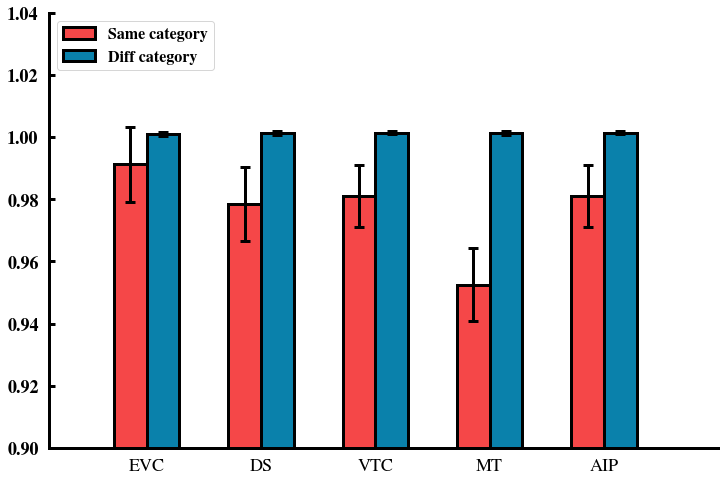

In [4]:
import os 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import join as pjoin
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams.update({'font.size': 12, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

corr_within_mean = corr_same_sum[0, :]
corr_within_std = corr_same_sum[1, :]
corr_between_mean = corr_diff_sum[0, :]
corr_between_std = corr_diff_sum[1, :]

width = 0.2
labels = mask_sum
x_1 = 0.7*np.arange(corr_within_mean.shape[0])
x_2 = x_1 + width

plt.figure(figsize=(12, 8))
plt.bar(x_1, corr_within_mean, yerr=corr_within_std, label='Same category', color='#F54748', 
        width=width, edgecolor='black', linewidth=3, error_kw=dict(lw=3, capsize=5, capthick=3), ecolor = "black")
plt.bar(x_2, corr_between_mean, yerr=corr_between_std, label='Diff category', color='#0A81AB', 
        width=width, edgecolor='black', linewidth=3, error_kw=dict(lw=3, capsize=5, capthick=3), ecolor = "black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax = plt.gca()
# ax.set_ylabel('Pattern Correlation', weight='bold', size=20, label)
ax.tick_params(labelsize=18, width=3, length=6, direction="in", pad=10)

plt.xticks((x_1 + x_2)/2, labels, weight='bold', fontsize=20)
plt.yticks(weight='bold')
plt.legend(loc='upper left', prop={'size':16, 'weight':'bold'})

ax.set_ylim(0.9, 1.04)
ax.set_xlim(-0.5, 3.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['bottom'].set_position(('data', 0.9))
ax.spines['left'].set_linewidth(3)

#### ISC part
##### Voxel-wise correlation of 180x1 category response between subjects. We use leave-one-out strategy here to compute ISC

In [3]:
from scipy.stats import pearsonr

# generate surface map for tSNR
def save_ciftifile(data, filename):
    template = '/nfs/z1/zhenlab/BrainImageNet/NaturalObject/data/bold/Analysis_derivatives/ciftify/sub-core02/MNINonLinear/Results/ses-ImageNet01_task-object_run-1/ses-ImageNet01_task-object_run-1_Atlas.dtseries.nii'
    ex_cii = nib.load(template)
    if len(data.shape) > 1:
        ex_cii.header.get_index_map(0).number_of_series_points = data.shape[0]
    else:
        ex_cii.header.get_index_map(0).number_of_series_points = 1
        data = data[np.newaxis, :]
    nib.save(nib.Cifti2Image(data.astype(np.float32), ex_cii.header), filename)

# Load beta for 30 subjects 
sub_names = sorted([i for i in os.listdir(beta_path) if i.startswith('sub')])
result_path = '/nfs/z1/userhome/ZhouMing/workingdir/BIN/action/utils/HAD/result/brain_map'
n_sub = len(sub_names)
n_class = 180

isc_path = pjoin(result_path, f'isc.dtseries.nii')
if not os.path.exists(isc_path):
    # load beta
    beta_sum = np.zeros((n_sub, n_class, 59412))
    for sub_idx, sub_name in enumerate(sub_names):
        # define beta path
        beta_sub_path = pjoin(beta_path, sub_name, f'{sub_name}_action-beta_clean.npy')
        beta_sub = np.load(beta_sub_path)
        scaler = StandardScaler()
        beta_sum[sub_idx] = scaler.fit_transform(beta_sub)
        print('Finish load data:%s'%sub_name)
    # compute ISC
    isc_map = np.zeros((n_sub, 59412))
    for voxel_idx in range(beta_sum.shape[-1]):
        voxel_pattern = beta_sum[:, :, voxel_idx]
        # ISC was computed by correlation of each per participant with the mean pattern of remaining n-1 participants
        for sub_idx in range(n_sub):
            target_pattern = voxel_pattern[sub_idx]
            mean_pattern = voxel_pattern[np.delete(np.arange(n_sub), sub_idx)].mean(axis=0)
            isc_map[sub_idx, voxel_idx] = pearsonr(target_pattern, mean_pattern)[0]
        print('Finish voxel:%05d'%voxel_idx)
    isc_map = isc_map.mean(axis=0)
    # save isc map
    isc_map_save = np.zeros((91282))
    isc_map_save[:59412] = isc_map
    save_ciftifile(isc_map_save, pjoin(result_path, f'isc.dtseries.nii'))
else:
    isc_map = np.array(nib.load(isc_path).get_fdata().tolist()).squeeze()[:59412]


0.20736551538409748
-0.012505005206912756
0.17856369316577897


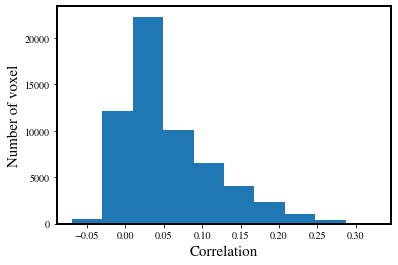

In [3]:
plt.xlabel('Correlation', size=15)
plt.ylabel('Number of voxel', size=15)
thresh = 0.1
plt.hist(isc_map)
print((isc_map>thresh).sum()/isc_map.shape[0])
print(np.percentile(isc_map, 5))
print(np.percentile(isc_map, 95))

#### Plot ISC distribution in different networks

In [10]:
# define path
main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
network_path = '/nfs/z1/atlas/ColeAnticevicNetPartition'
roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
roi_path = pjoin(main_path, 'MMP_mpmLR32k.mat')

# load network partition info
roi = sio.loadmat(roi_path)['glasser_MMP']
roi_names = pd.read_csv(roi_name_path)
network = sio.loadmat(pjoin(network_path, 'cortex_parcel_network_assignments.mat'))['netassignments'] 
network = [x[0] for x in network]

# obtain network name
with open(pjoin(network_path, 'network_labelfile.txt'), 'r') as f:
    text = f.readlines()
network_names = [x.strip('\n') for x in text if not x[0].isdigit()]
network_order = [int(x.split(' ')[0].strip('\n')) for x in text if x[0].isdigit()]

# transform network name order for better plotting
network_names_refine = ['Primary Visual', 'Secondary Visual', 'Ventral Multimodal', 'Posterior Multimodal', 'Somatomotor', 'Dorsal-attention',
                        'Cingulo-Opercular', 'Language', 'Default', 'Frontoparietal', 'Auditory', 'Orbito-Affective']
network_order_refine = [network_order[network_names.index(x)] for x in network_names_refine]

# extract target cnr value
network_partition = np.zeros(59412)
for loop_idx, network_idx in enumerate(network_order_refine):
    network_name = network_names_refine[loop_idx]
    roi_index = [idx+1 for idx,x in enumerate(network) if x in [network_idx]]
    voxel_selected = np.asarray([True if x in roi_index else False for x in roi[0]])
    network_partition[voxel_selected] = loop_idx+1
    print('%05d voxels in %s'%(voxel_selected.sum(), network_name))


02138 voxels in Primary Visual
06817 voxels in Secondary Visual
01139 voxels in Ventral Multimodal
00937 voxels in Posterior Multimodal
10011 voxels in Somatomotor
03810 voxels in Dorsal-attention
09152 voxels in Cingulo-Opercular
03332 voxels in Language
11598 voxels in Default
08099 voxels in Frontoparietal
01664 voxels in Auditory
00715 voxels in Orbito-Affective


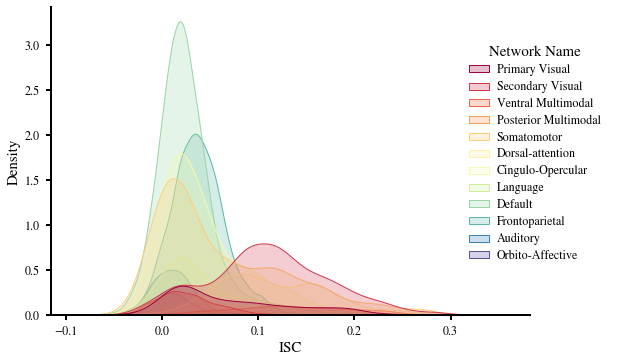

In [11]:
import seaborn as sns

sns.reset_orig()
# sns.set_style(style='white')
# sns.set(font="STIXGeneral")
mpl.rcParams['font.family'] = 'STIXGeneral'

# make cnr dataframe
cnr_info = pd.DataFrame(np.concatenate((isc_map[:, np.newaxis], network_partition[:, np.newaxis]), axis=1), columns=['isc', 'Network Name'])
# distribution plot
ax = sns.displot(data=cnr_info, x='isc', hue='Network Name', kind='kde', 
                 fill=True, height=5, aspect=1.5, palette=sns.color_palette('Spectral', as_cmap=True))

# for legend text
for t, l in zip(ax._legend.texts, network_names_refine):
    t.set_text(l)
plt.setp(ax._legend.get_texts(), fontsize='12') 
plt.setp(ax._legend.get_title(), fontsize='15') 
ax._legend.set_bbox_to_anchor((1, 0.58)) # left → right, down → up

# Add some text for labels, title and custom x-axis tick labels, etc.
plt.xlabel('ISC', fontsize=15)
plt.ylabel('Density', fontsize=15)
ax = plt.gca()
ax.tick_params(labelsize=12, width=2, length=5, direction="out", pad=6)
# ax.set_xlim(-0.6, 2.5)
# ax.set_ylim(0, 0.75)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)


#### Demonstrated the ROI in visual cortex and sort them using higher discrimination, like MT+, Dorsal area. ventral temporal, early visual cortex

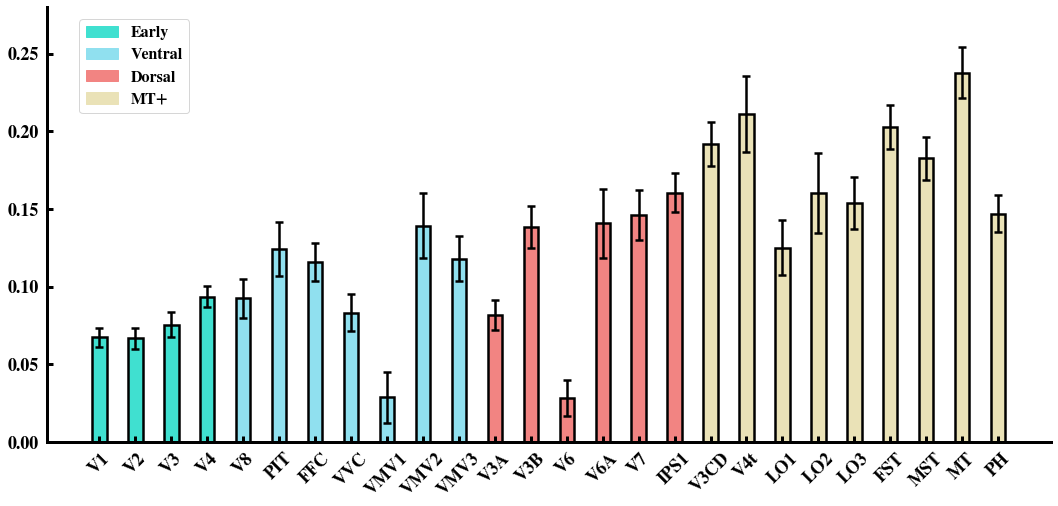

In [25]:
import matplotlib.patches as mpatches

def roi_mask(roi_name):
    """
        roi_name : list or str
    """
    # load reference info
    main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
    roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
    roi_names = pd.read_csv(roi_name_path)
    roi = sio.loadmat(pjoin(main_path, 'MMP_mpmLR32k.mat'))['glasser_MMP']  # 1x59412

    # start load name
    roi_index = []
    if isinstance(roi_name, str):
        roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{roi_name}_ROI']).any(axis=1)].index[0]+1
        roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    else:
        for name in roi_name:
            roi_tmp_index = roi_names.loc[roi_names.isin([f'L_{name}_ROI']).any(axis=1)].index[0]+1
            roi_index.extend([roi_tmp_index, roi_tmp_index+180])
        mask = np.asarray([True if x in roi_index else False for x in roi[0]])
    return mask

# define threshold
isc_thresh = np.percentile(isc_map, 95)

# Iterate to discover the high CNR ROI
main_path = '/nfs/z1/zhenlab/BrainImageNet/Analysis_results/'
roi_name_path = pjoin(main_path, 'roilbl_mmp.csv')
roi_names = pd.read_csv(roi_name_path).iloc[:, 0].tolist()

roi_target = {'Early': ['V1', 'V2', 'V3', 'V4'],              
              'Ventral': ['V8', 'PIT', 'FFC', 'VVC', 'VMV1', 'VMV2', 'VMV3'],
              'Dorsal': ['V3A', 'V3B', 'V6', 'V6A', 'V7', 'IPS1'],
              'MT+': ['V3CD', 'V4t', 'LO1', 'LO2', 'LO3', 'FST', 'MST', 'MT', 'PH']
            }

isc_roi = np.zeros((2, 26))
colors_region = ['#40E0D0', '#90e0ef', '#f28482', '#eae2b7']
roi_idx, labels, colors = 0, [], []
for region_idx, region in enumerate(roi_target.keys()):
    roi_sum = roi_target[region]
    colors.extend([colors_region[region_idx] for x in range(len(roi_sum))])
    for roi in roi_sum:
        tmp_mask = roi_mask(roi)
        isc_roi[0, roi_idx] = isc_map[tmp_mask].mean()
        isc_roi[1, roi_idx] = np.sqrt(isc_map[tmp_mask].std()/tmp_mask.sum())
        roi_idx += 1
        labels.append(roi)

width = 0.2
x_1 = 0.5*np.arange(len(labels))

plt.figure(figsize=(18, 8))
plt.bar(x_1, isc_roi[0], yerr=isc_roi[1], color=colors, 
        width=width, edgecolor='black', linewidth=2.5, error_kw=dict(lw=2.5, capsize=4, capthick=2.5), ecolor = "black")

# manually add color legend
handles = []
for region_idx, region in enumerate(roi_target.keys()):
    handles.append(mpatches.Patch(color=colors_region[region_idx], label=region))
plt.legend(handles=handles, bbox_to_anchor = (0.15, 0.99), prop={'size':16, 'weight':'bold'})

# Add some text for labels, title and custom x-axis tick labels, etc.
ax = plt.gca()
# ax.set_ylabel('Pattern Correlation', weight='bold', size=20, label)
ax.tick_params(labelsize=18, width=3, length=6, direction="in", pad=8)
plt.xticks(x_1, labels, weight='bold', fontsize=18, rotation=45)
plt.yticks(weight='bold')
ax.set_ylim(0, 0.28)
# ax.set_xlim(-0.5, 2.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
# ax.spines['bottom'].set_position(('data', 0.9))
ax.spines['left'].set_linewidth(3)


#### Itegrate ISC value in target ROI

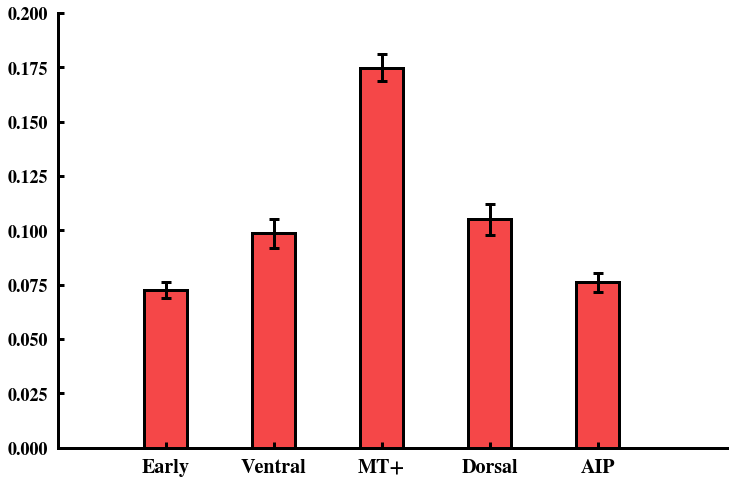

In [24]:

# bar plot of specified ROI: ISC mean and std
isc_roi = np.zeros((2, len(roi_sum)))
roi_sum = ['Early', 'Ventral', 'MT', 'Dorsal', 'AIP']
for roi_idx, roi in enumerate(roi_sum):
    tmp_mask = roi_mask(eval(f'{roi}_name'))
    isc_roi[0, roi_idx] = isc_map[tmp_mask].mean()
    isc_roi[1, roi_idx] = np.sqrt(isc_map[tmp_mask].std()/tmp_mask.sum())

width = 0.2
labels = [x+'+' if x =='MT' else x for x in roi_sum]
x_1 = 0.5*np.arange(len(roi_sum))

plt.figure(figsize=(12, 8))
plt.bar(x_1, isc_roi[0], yerr=isc_roi[1], color='#F54748', 
        width=width, edgecolor='black', linewidth=3, error_kw=dict(lw=3, capsize=5, capthick=3), ecolor = "black")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax = plt.gca()
# ax.set_ylabel('Pattern Correlation', weight='bold', size=20, label)
ax.tick_params(labelsize=18, width=3, length=6, direction="in", pad=10)

plt.xticks(x_1, labels, weight='bold', fontsize=20)
plt.yticks(weight='bold')
# plt.legend(loc='upper left', prop={'size':16, 'weight':'bold'})

ax.set_ylim(0, 0.2)
ax.set_xlim(-0.5, 2.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
# ax.spines['bottom'].set_position(('data', 0.9))
ax.spines['left'].set_linewidth(3)